In [1]:
# Import Libraries
import json
import nltk
import time
import random
import string
import pickle
import numpy as np
import pandas as pd
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\thiod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\thiod\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\thiod\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Importing the dataset
with open('dataset.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [4]:
data

,patterns,tags
0,Hai,greetings
1,Pagi,greetings
2,Siang,greetings
3,Sist,greetings
4,P,greetings
...,...,...
143,Bagaimana tanggapanmu terhadap pengalaman meng...,feedback
144,Bagaimana penilaianmu terhadap layanan SmartSkin?,feedback
145,Bagaimana kesanmu setelah mendapatkan saran pe...,feedback
146,Bisakah kamu berbagi feedback tentang perawata...,feedback


In [5]:
data.head()

,patterns,tags
0,Hai,greetings
1,Pagi,greetings
2,Siang,greetings
3,Sist,greetings
4,P,greetings


In [6]:
data.tail()

,patterns,tags
143,Bagaimana tanggapanmu terhadap pengalaman meng...,feedback
144,Bagaimana penilaianmu terhadap layanan SmartSkin?,feedback
145,Bagaimana kesanmu setelah mendapatkan saran pe...,feedback
146,Bisakah kamu berbagi feedback tentang perawata...,feedback
147,Apakah kamu memiliki komentar atau saran untuk...,feedback


In [7]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hai,greetings
1,pagi,greetings
2,siang,greetings
3,sist,greetings
4,p,greetings
...,...,...
143,bagaimana tanggapanmu terhadap pengalaman meng...,feedback
144,bagaimana penilaianmu terhadap layanan smartskin,feedback
145,bagaimana kesanmu setelah mendapatkan saran pe...,feedback
146,bisakah kamu berbagi feedback tentang perawata...,feedback


In [8]:
lemmatizer = WordNetLemmatizer()
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

print (len(words), "unique lemmatized words", words)

238 unique lemmatized words [',', '.', '16', '28', '50', 'ada', 'adalah', 'admin', 'agak', 'ai', 'alami', 'aman', 'anda', 'antara', 'apa', 'apakah', 'area', 'assistant', 'atau', 'bagaimana', 'bagus', 'bahan', 'bahan-bahan', 'balik', 'balikmu', 'bantu', 'bantuan', 'banyak', 'beberapa', 'bekas', 'berbagi', 'berikan', 'berjerawat', 'berlebih', 'berminyak', 'bertanya', 'berusia', 'bingung', 'bisa', 'bisakah', 'bot', 'butuh', 'butuhkan', 'c', 'cara', 'cenderung', 'cerah', 'cerdas', 'chatbot', 'coba', 'cocok', 'dan', 'dapat', 'dari', 'datang', 'dehidrasi', 'dengan', 'di', 'dibantu', 'diberikan', 'dibutuhkannya', 'dilakukan', 'dimaksud', 'dini', 'disebut', 'diskusikan', 'efektif', 'eh', 'feedback', 'gunakan', 'hai', 'halo', 'hari', 'harus', 'hei', 'hitam', 'informasi', 'ingin', 'ini', 'iritasi', 'itu', 'jenis', 'jerawat', 'kabar', 'kak', 'kamu', 'kapan', 'kasar', 'kasih', 'keluhan', 'kemerahan', 'kering', 'kesanmu', 'ketat', 'khawatir', 'kimia', 'kombinasi', 'komentar', 'kulit', 'kusam', 'lai

In [9]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

65 classes ['feedback', 'greetings', 'not_found', 'product_ingredients', 'produk', 'produk1', 'produk10', 'produk11', 'produk12', 'produk13', 'produk14', 'produk15', 'produk16', 'produk17', 'produk18', 'produk19', 'produk2', 'produk20', 'produk21', 'produk3', 'produk4', 'produk5', 'produk6', 'produk7', 'produk8', 'produk9', 'skin_problems', 'skin_problems1', 'skin_problems10', 'skin_problems11', 'skin_problems12', 'skin_problems13', 'skin_problems14', 'skin_problems15', 'skin_problems16', 'skin_problems2', 'skin_problems3', 'skin_problems4', 'skin_problems5', 'skin_problems6', 'skin_problems7', 'skin_problems8', 'skin_problems9', 'skintipe alami', 'skintipe berminyak1', 'skintipe berminyak2', 'skintipe kering', 'skintipe kombinasi1', 'skintipe kombinasi2', 'skintipe normal2', 'skintipe sensitif', 'skintipe1', 'skintipe2', 'skintipe3', 'skintipe4', 'skintipe5', 'skintipe_berjerawat1', 'skintipe_normal1', 'skintype', 'thank_you', 'treatment_time', 'treatment_time1', 'treatment_time2', 't

In [10]:
# documents = combination between patterns and intents
print (len(documents), "documents")

1342 documents


In [11]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])

In [12]:
# Apply padding
x_train = pad_sequences(train)

# Encoding the outputs
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [13]:
print(x_train) # Padding Sequences

[[  0   0   0 ...   0   0  22]
 [  0   0   0 ...   0   0  36]
 [  0   0   0 ...   0   0 113]
 ...
 [  0   0   0 ...   2  77  27]
 [  0   0   0 ...   2  26  27]
 [  0   0  34 ... 236   9   2]]


In [15]:
print(y_train) #Label Encodings

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 58 44 57 57 57 57 57 47 51 56 52 53 48 54 55 45 43 50
 49 46  4  5 16 19 20 21 22 23 24 25  6  7  8  9 10 11 12 13 14 15 17 18
 27 27 27 27 27 35 35 35 35 35 36 36 36 36 36 37 37 37 37 37 38 38 38 38
 38 39 39 39 39 39 40 41 42 28 29 30 31 32 33 34 26 60 61 62 63  3  3  3
  3  3 64 64 64 64 59 59 59 59 59 59 59  2  2  2  2  2  0  0  0  0  0  0
  0  0  0  0]


In [16]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

13


In [17]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  236
output length:  65


In [18]:
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))

In [19]:
pickle.dump(le, open('labelencoder.pkl','wb'))
pickle.dump(tokenizer, open('tokenizer.pkl','wb'))

In [20]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [21]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='/static/img/model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
model.summary() # Menampilkan Parameter Model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 embedding (Embedding)       (None, 13, 10)            2370      
                                                                 
 lstm (LSTM)                 (None, 13, 10)            840       
                                                                 
 flatten (Flatten)           (None, 130)               0         
                                                                 
 dense (Dense)               (None, 65)                8515      
                                                                 
Total params: 11725 (45.80 KB)
Trainable params: 11725 (45.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# Training the model (Latih Model Data)
train = model.fit(x_train, y_train, epochs=400)

Epoch 1/400
5/5 [==============================] - 3s 7ms/step - loss: 4.1718 - accuracy: 0.0270
Epoch 2/400
5/5 [==============================] - 0s 6ms/step - loss: 4.1598 - accuracy: 0.1554
Epoch 3/400
5/5 [==============================] - 0s 6ms/step - loss: 4.1447 - accuracy: 0.2162
Epoch 4/400
5/5 [==============================] - 0s 6ms/step - loss: 4.1241 - accuracy: 0.2027
Epoch 5/400
5/5 [==============================] - 0s 6ms/step - loss: 4.0914 - accuracy: 0.2027
Epoch 6/400
5/5 [==============================] - 0s 6ms/step - loss: 4.0483 - accuracy: 0.2027
Epoch 7/400
5/5 [==============================] - 0s 6ms/step - loss: 3.9835 - accuracy: 0.2027
Epoch 8/400
5/5 [==============================] - 0s 6ms/step - loss: 3.8974 - accuracy: 0.2027
Epoch 9/400
5/5 [==============================] - 0s 7ms/step - loss: 3.7801 - accuracy: 0.2027
Epoch 10/400
5/5 [==============================] - 0s 6ms/step - loss: 3.6586 - accuracy: 0.2027
Epoch 11/400
5/5 [===========

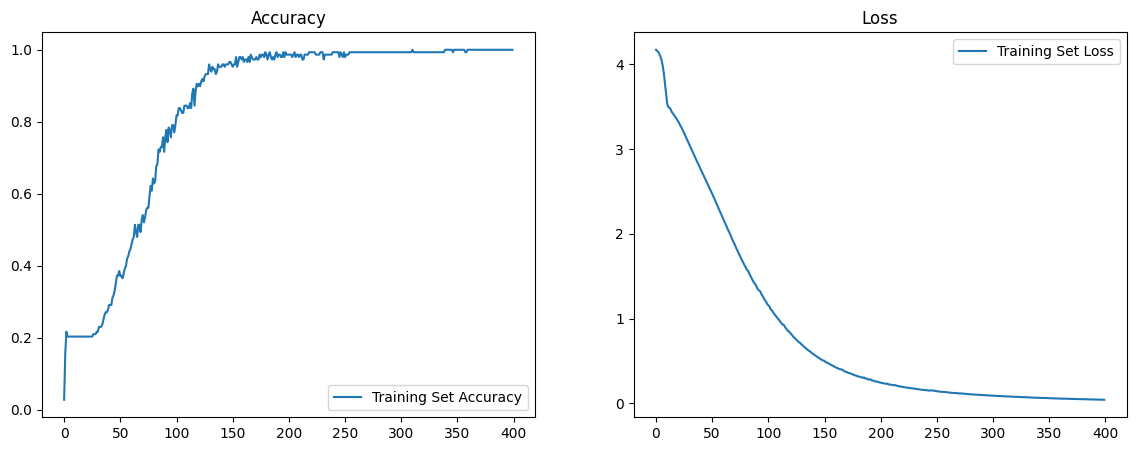

In [24]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on train data")
print("Training Set Accuracy: ", train.history['accuracy'][-1])
print("Training Set Loss: ", train.history['loss'][-1])

Evaluate on train data
Training Set Accuracy:  1.0
Training Set Loss:  0.04123033583164215


In [26]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Kamu : ')

  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model
  output = model.predict(prediction_input)
  output = output.argmax()

# # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("SmartSkin : ", random.choice(responses[response_tag]))
  # tts = gTTS(random.choice(responses[response_tag]), lang='id')
  # tts.save('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KadekBot.wav')
  # time.sleep(0.08)
  # ipd.display(ipd.Audio('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KadekBot.wav', autoplay=True))
  print("="*60 + "\n")
  if response_tag == "goodbye":
    break

1/1 [==============================] - 0s 473ms/step
SmartSkin :  Halo, terima kasih telah menghubungi SmartSkin. Perkenalkan, Saya SmartSkin yang akan membantu Anda dalam menangani permasalahan kulit Anda. Ada yang dapat saya bantu?

1/1 [==============================] - 0s 22ms/step
SmartSkin :  Paham, kulit kering membutuhkan kelembapan ekstra. Saya merekomendasikan produk perawatan yang mengandung asam hialuronat atau minyak alami seperti minyak argan untuk melembapkan kulit Anda

1/1 [==============================] - 0s 29ms/step
SmartSkin :  Sama-sama! Jangan ragu untuk menghubungi kami jika Anda membutuhkan bantuan lebih lanjut.



KeyboardInterrupt: Interrupted by user

In [25]:
model.save('chat_model.h5')

print('Model Created Successfully!')

Model Created Successfully!


c:\Users\thiod\OneDrive\Desktop\chatbot-smartskin\my-venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
